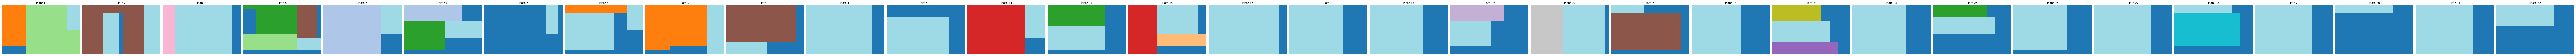

9250


In [ ]:
import numpy as np
import heapq
import matplotlib
import matplotlib.pyplot as plt
from tabulate import tabulate

class PlatesManager:
    def __init__(self, plate_width, plate_height):
        """
        Initializes the PlatesManager with the dimensions for the plates.
        """
        self.plate_width = plate_width
        self.plate_height = plate_height
        self.plates = []  # List of plates (bitmaps for space tracking)
        self.available_slots = []  # Priority queue to track available slots
        
    def create(self):
        """
        Create an initial plate with the specified size.
        """
        # Using a 2D array (bitmap) to represent free space (0 = free, 1 = occupied)
        initial_plate = np.zeros((self.plate_height, self.plate_width), dtype=int)
        self.plates.append(initial_plate)
        # Push the initial plate into the available slots heap (with priority on available space)
        heapq.heappush(self.available_slots, (self.plate_width * self.plate_height, 0))

    def find_and_place_rectangle(self, rect_width, rect_height, fill_value, rotate=False):
        """
        Try to place a rectangle on the first available plate or split it if it's too large.
        """
        cost = 0
        order = []
        
        # Handle large rectangles that might require splitting
        if rect_width > self.plate_width or rect_height > self.plate_height:
            sub_rectangles = self.split_large_rectangle(rect_width, rect_height)
            cost, order = self.place_sub_rectangles(sub_rectangles, fill_value)
        else:
            # If the rectangle fits within the plate size, proceed as normal
            cost, order = self.place_rectangle_on_existing_plates(rect_width, rect_height, fill_value)

        if rotate:
            rect_width, rect_height = rect_height, rect_width
            if rect_width > self.plate_width or rect_height > self.plate_height:
                sub_rectangles = self.split_large_rectangle(rect_width, rect_height)
                costR, orderR = self.place_sub_rectangles(sub_rectangles, fill_value)
            else:
                costR, orderR = self.place_rectangle_on_existing_plates(rect_width, rect_height, fill_value)
            if costR < cost:
                cost = costR
                order = orderR
                
        self.plates = order
        return cost

    def split_large_rectangle(self, rect_width, rect_height):
        """
        Splits the large rectangle into smaller sub-rectangles.
        """
        sub_rectangles = []
        while rect_width > self.plate_width or rect_height > self.plate_height:
            if rect_width > self.plate_width:
                sub_rectangles.append((self.plate_width, rect_height))
                rect_width -= self.plate_width
            elif rect_height > self.plate_height:
                sub_rectangles.append((rect_width, self.plate_height))
                rect_height -= self.plate_height

        if rect_width <= self.plate_width and rect_height <= self.plate_height:
            sub_rectangles.append((rect_width, rect_height))

        return sub_rectangles

    def place_sub_rectangles(self, sub_rectangles, fill_value):
        """
        Place the sub-rectangles onto the plates, reusing space or creating new plates as necessary.
        This version uses bitmaps for efficient space tracking.
        """
        new_plates = [plate.copy() for plate in self.plates]  # Make a copy of the current plates
        
        for sub_width, sub_height in sub_rectangles:
            placed = False
            while not placed:
                if self.available_slots:
                    available_space, plate_index = heapq.heappop(self.available_slots)
                    plate = new_plates[plate_index]
                    rows, cols = plate.shape
                    for i in range(rows - sub_height + 1):
                        for j in range(cols - sub_width + 1):
                            if np.all(plate[i:i + sub_height, j:j + sub_width] == 0):  # Slot found
                                plate[i:i + sub_height, j:j + sub_width] = fill_value
                                new_available_space = available_space - (sub_width * sub_height)
                                heapq.heappush(self.available_slots, (new_available_space, plate_index))
                                placed = True
                                break
                    if placed:
                        break
                if not placed:
                    new_plate = np.zeros((self.plate_height, self.plate_width), dtype=int)
                    new_plates.append(new_plate)
                    heapq.heappush(self.available_slots, (self.plate_width * self.plate_height, len(new_plates) - 1))
                    new_plate[:sub_height, :sub_width] = fill_value
                    placed = True

        cost = self.calculate_cost(new_plates)
        return cost, new_plates  # Return the new plates list

    def place_rectangle_on_existing_plates(self, rect_width, rect_height, fill_value):
        """
        Tries to place a regular rectangle on existing plates, without modifying the original plates.
        """
        new_plates = [plate.copy() for plate in self.plates]  # Create a copy of self.plates

        for plate in new_plates:
            rows, cols = plate.shape
            for i in range(rows - rect_height + 1):
                for j in range(cols - rect_width + 1):
                    if np.all(plate[i:i + rect_height, j:j + rect_width] == 0):  # Slot found
                        plate[i:i + rect_height, j:j + rect_width] = fill_value
                        cost = self.calculate_cost(new_plates)
                        return cost, new_plates

        new_plate = np.zeros((self.plate_height, self.plate_width), dtype=int)
        new_plates.append(new_plate)
        new_plate[:rect_height, :rect_width] = fill_value

        cost = self.calculate_cost(new_plates)
        return cost, new_plates  # Return the copy of plates

    def calculate_cost(self, plates):
        """
        Calculate the cost of the plate arrangement based on the number of plates used
        and the unused space on each plate.
        """
        num_plates = len(plates)
        unused_space = 0  # Track unused space in each plate
        
        for plate in plates:
            unused_space += np.count_nonzero(plate == 0)

        cost = num_plates * (self.plate_width * self.plate_height) + unused_space
        return cost

    def print_plates(self):
        """
        Prints the list of plates in a nicely formatted table.
        """
        for i, plate in enumerate(self.plates):
            print(f"Plate {i + 1}:")
            print(tabulate(plate, tablefmt="grid", numalign="center", stralign="center"))
            print("\n")

    def plot_plates(self):
        """
        Visualizes the list of plates using matplotlib with color-coded rectangles.
        """
        num_plates = len(self.plates)
        
        fig, axes = plt.subplots(1, num_plates, figsize=(5 * num_plates, 5))
        if num_plates == 1:
            axes = [axes]
        
        cmap = matplotlib.colormaps['tab20']
        color_map = {i: cmap(i / len(self.plates)) for i in range(len(self.plates))}

        for i, plate in enumerate(self.plates):
            ax = axes[i]
            ax.imshow(plate, cmap=cmap, interpolation='nearest')
            ax.set_title(f"Plate {i + 1}")
            ax.grid(True)
            ax.set_xticks([])  # Hide x ticks
            ax.set_yticks([])  # Hide y ticks
            ax.axis('off')

        plt.tight_layout()
        plt.show()


# Example usage:
if __name__ == "__main__":
    plates_manager = PlatesManager(19, 12)
    plates_manager.create()  # Create initial plate

    # Example of placing 50 random rectangles between 127 and 1870
    for i in range(50):
        rect_width = np.random.randint(3, 18)
        rect_height = np.random.randint(3, 18)
        fill_value = np.random.randint(1, i+2)
        plates_manager.find_and_place_rectangle(rect_width, rect_height, fill_value)

    plates_manager.plot_plates()  # Plot the plates
    #plates_manager.print_plates()  # Print the plates in table format
    print(plates_manager.calculate_cost(plates_manager.plates))
